In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
from sklearn.model_selection import train_test_split
import mysql.connector

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_data(query):
    host = os.environ.get("MYSQL_HOST", "localhost")
    port = os.environ.get("MYSQL_PORT", "3306")
    dbname = os.environ.get("MYSQL_DBNAME", "analytics_project")
    user = os.environ.get("MYSQL_USER", "root")
    password = os.environ.get("MYSQL_PASSWORD", "")

    try:
        conn = mysql.connector.connect( 
            host=host,
            port=port,
            user=user,
            password=password,
            database=dbname
        )
        if conn.is_connected():
            # Create a cursor
            cursor = conn.cursor()
            
            # Execute the query
            cursor.execute(query)
            
            # Fetch the results into a Pandas DataFrame
            result = cursor.fetchall()
            df = pd.DataFrame(result, columns=cursor.column_names)
            return df
        else:
            print("Connection to MySQL database failed.")
    except mysql.connector.Error as err:
        print(f"Error: {err}")

In [3]:
# Getting charger data from MySQL database with custom query
query = "SELECT canton, COUNT(*) AS count FROM charger_data_with_canton GROUP BY canton ORDER BY canton ASC"

# Get data from MySQL database
df_canton_count = get_data(query)
df_canton_count.loc[df_canton_count['canton'] == 'Fribourg', 'canton'] = 'Freiburg'

query = "SELECT * FROM canton_data ORDER By canton ASC"

df_canton_data = get_data(query)

print(df_canton_count)
print(df_canton_data)

# Merge dataframes
df = pd.merge(df_canton_data, df_canton_count, on='canton')

df

                    canton  count
0                   Aargau    917
1   Appenzell Ausserrhoden     54
2    Appenzell Innerrhoden     24
3         Basel-Landschaft    362
4              Basel-Stadt    223
5               Bern/Berne   1189
6                 Freiburg    377
7                   Genève    684
8                   Glarus     86
9      Graubünden/Grigioni    709
10                    Jura     71
11                  Luzern    707
12               Neuchâtel    231
13               Nidwalden     81
14                Obwalden     69
15            Schaffhausen    128
16                  Schwyz    246
17               Solothurn    310
18              St. Gallen    844
19                 Thurgau    276
20                  Ticino    705
21                     Uri    119
22           Valais/Wallis    875
23                    Vaud   1081
24                     Zug    379
25                  Zürich   1729
     canton abbreviation  popDens  medianIncome  inhabitants  rural
0    Aargau   

,canton,abbreviation,popDens,medianIncome,inhabitants,rural,count
0,Aargau,AG,510.0,75391,711232,1,917
1,Aargau,AG,510.0,75402,711232,1,917
2,Aargau,AG,510.0,75402,711232,1,917
3,Aargau,AG,510.0,75392,711232,1,917
4,Aargau,AG,510.0,75398,711232,1,917
...,...,...,...,...,...,...,...
109,Zürich,ZH,951.0,83264,1579967,0,1729
110,Zürich,ZH,951.0,83187,1579967,0,1729
111,Zürich,ZH,951.0,83247,1579967,0,1729
112,Zürich,ZH,951.0,83187,1579967,0,1729


In [4]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df['inhabitants'], 
                                                    df['count'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
31      334465
67       85214
111    1579967
108    1579967
22      294417
Name: inhabitants, dtype: int64 

y_train:
31      377
67      128
111    1729
108    1729
22      362
Name: count, dtype: int64


In [5]:
# Fit the regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            57.44
Slope of regression line (beta):          0.001
p-value:                                  0.0000
R-squared (coefficient of determination): 0.9512


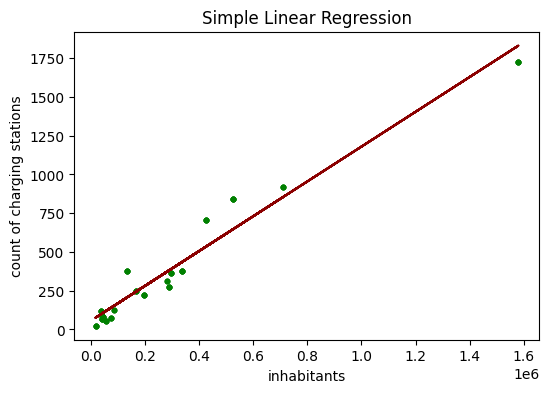

In [6]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('inhabitants')
plt.ylabel('count of charging stations')

plt.show()

# Interpretation
So if we look at the given values of the regression, we can see, that we have a p-value of 0.0000 which for us means, that our statistics are statistically relevant. Also our r-squared value is 0.9194, which means, that 91.94% of all chargingstations can be explained through the amount of inhabitant in a canton. Our beta is 0.001 which can interpreted as: If there is one more inhabitant, there would have to be 0.001 more chargingstation.


In [7]:
# Calculate model residuals for train data
print(mymodel)
print(y_train)
residuals = y_train - mymodel
print(residuals)

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {mymodel.iloc[0]:.2f}')
print(f'1st Observed price in dataset: {y_train.iloc[0]:.2f}')
print(f'1st Residual price in dataset: {residuals.iloc[0]:.2f}')

0      432.846797
1      153.081561
2     1830.827794
3     1830.827794
4      387.895972
         ...     
86     204.656931
87      75.861054
88     382.545378
89     534.298188
90     204.656931
Length: 91, dtype: float64
31      377
67      128
111    1729
108    1729
22      362
       ... 
106     379
14       24
92      276
51      707
102     379
Name: count, Length: 91, dtype: int64
0             NaN
1      763.918439
2     -913.827794
3     -913.827794
4             NaN
          ...    
108           NaN
109           NaN
110           NaN
111           NaN
113           NaN
Length: 110, dtype: float64
1st Predicted price in dataset: 432.85
1st Observed price in dataset: 377.00
1st Residual price in dataset: nan


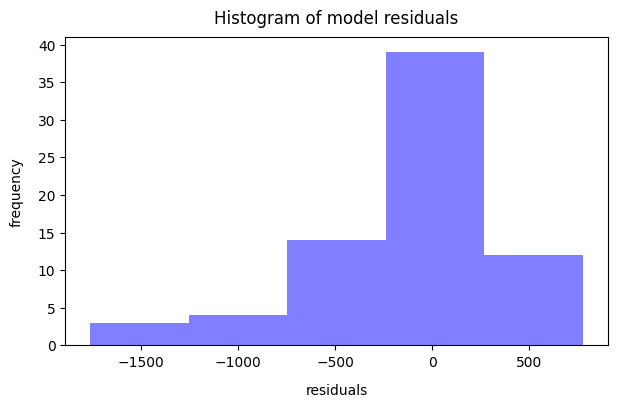

In [8]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=5, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

<Axes: >

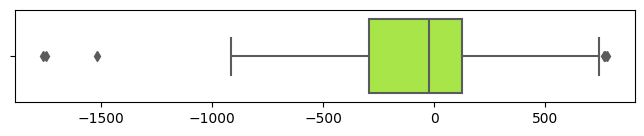

In [9]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=residuals, color="greenyellow")

In [10]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Get the minimum length of y_test and predicted
min_length = min(len(y_test), len(predicted))

# Compare the observed prices with the predicted prices
for i in range(min_length):
    print(f'Observed count of chargers: {y_test.iloc[i]:.1f}, Predicted count of chargers: {predicted.iloc[i]:.1f}')

Observed count of chargers: 310.0, Predicted count of chargers: 374.4
Observed count of chargers: 917.0, Predicted count of chargers: 855.7
Observed count of chargers: 86.0, Predicted count of chargers: 104.0
Observed count of chargers: 128.0, Predicted count of chargers: 153.1
Observed count of chargers: 54.0, Predicted count of chargers: 120.0
Observed count of chargers: 71.0, Predicted count of chargers: 140.3
Observed count of chargers: 128.0, Predicted count of chargers: 153.1
Observed count of chargers: 128.0, Predicted count of chargers: 153.1
Observed count of chargers: 71.0, Predicted count of chargers: 140.3
Observed count of chargers: 54.0, Predicted count of chargers: 120.0
Observed count of chargers: 119.0, Predicted count of chargers: 99.3
Observed count of chargers: 86.0, Predicted count of chargers: 104.0
Observed count of chargers: 310.0, Predicted count of chargers: 374.4
Observed count of chargers: 1729.0, Predicted count of chargers: 1830.8
Observed count of charger

# Now we want to check how the regressoin looks without the urban cantons
We define urban as cantons with a popDens higher than 900

In [11]:
# Write query that gets canton_data where rural is true
query = "SELECT * FROM canton_data WHERE rural = TRUE ORDER BY canton ASC"

df_canton_data = get_data(query)

# Merge dataframes
df_rural = pd.merge(df_canton_data, df_canton_count, on='canton')

df_rural

,canton,abbreviation,popDens,medianIncome,inhabitants,rural,count
0,Aargau,AG,510.0,75392,711232,1,917
1,Aargau,AG,510.0,75398,711232,1,917
2,Aargau,AG,510.0,75402,711232,1,917
3,Aargau,AG,510.0,75402,711232,1,917
4,Aargau,AG,510.0,75391,711232,1,917
...,...,...,...,...,...,...,...
97,Zug,ZG,633.0,84981,131164,1,379
98,Zug,ZG,633.0,84998,131164,1,379
99,Zug,ZG,633.0,84981,131164,1,379
100,Zug,ZG,633.0,85000,131164,1,379


In [12]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_rural['inhabitants'], 
                                                    df_rural['count'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
53     44420
22    294417
68    164920
44    424851
98    131164
Name: inhabitants, dtype: int64 

y_train:
53     81
22    362
68    246
44    707
98    379
Name: count, dtype: int64


In [13]:
# Fit the regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            14.83
Slope of regression line (beta):          0.001
p-value:                                  0.0000
R-squared (coefficient of determination): 0.9154


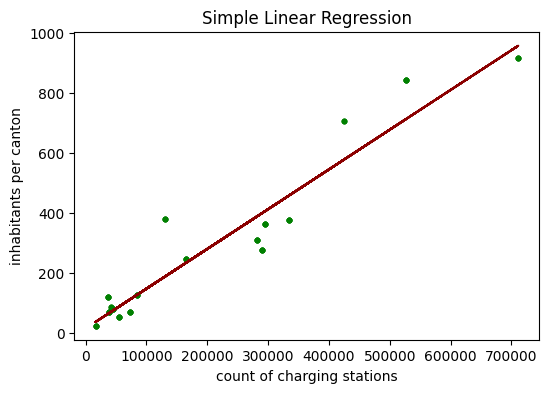

In [14]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('count of charging stations')
plt.ylabel('inhabitants per canton')

plt.show()

In [15]:
# Calculate model residuals for train data
print(mymodel)
print(y_train)
residuals_rural = y_train - mymodel
print(residuals)

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {mymodel.iloc[0]:.2f}')
print(f'1st Observed price in dataset: {y_train.iloc[0]:.2f}')
print(f'1st Residual price in dataset: {residuals.iloc[0]:.2f}')
residuals

0      73.752672
1     405.392409
2     233.604944
3     578.422876
4     188.825082
         ...    
76    127.868967
77    233.604944
78     36.603269
79     64.330011
80     73.752672
Length: 81, dtype: float64
53     81
22    362
68    246
44    707
98    379
     ... 
60    128
71    246
14     24
92    119
51     81
Name: count, Length: 81, dtype: int64
0             NaN
1      763.918439
2     -913.827794
3     -913.827794
4             NaN
          ...    
108           NaN
109           NaN
110           NaN
111           NaN
113           NaN
Length: 110, dtype: float64
1st Predicted price in dataset: 73.75
1st Observed price in dataset: 81.00
1st Residual price in dataset: nan


0             NaN
1      763.918439
2     -913.827794
3     -913.827794
4             NaN
          ...    
108           NaN
109           NaN
110           NaN
111           NaN
113           NaN
Length: 110, dtype: float64

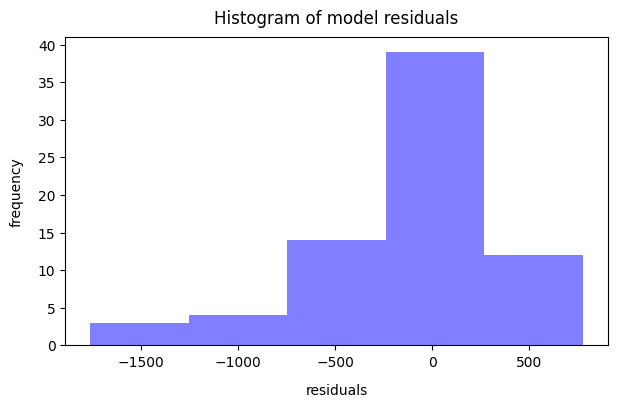

In [16]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=5, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

In [17]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Get the minimum length of y_test and predicted
min_length = min(len(y_test), len(predicted))

# Compare the observed prices with the predicted prices
for i in range(min_length):
    print(f'Observed count of chargers: {y_test.iloc[i]:.1f}, Predicted count of chargers: {predicted.iloc[i]:.1f}')

Observed count of chargers: 86.0, Predicted count of chargers: 69.8
Observed count of chargers: 246.0, Predicted count of chargers: 233.6
Observed count of chargers: 128.0, Predicted count of chargers: 127.9
Observed count of chargers: 707.0, Predicted count of chargers: 578.4
Observed count of chargers: 707.0, Predicted count of chargers: 578.4
Observed count of chargers: 71.0, Predicted count of chargers: 112.8
Observed count of chargers: 119.0, Predicted count of chargers: 64.3
Observed count of chargers: 707.0, Predicted count of chargers: 578.4
Observed count of chargers: 54.0, Predicted count of chargers: 88.8
Observed count of chargers: 917.0, Predicted count of chargers: 958.3
Observed count of chargers: 362.0, Predicted count of chargers: 405.4
Observed count of chargers: 86.0, Predicted count of chargers: 69.8
Observed count of chargers: 379.0, Predicted count of chargers: 188.8
Observed count of chargers: 276.0, Predicted count of chargers: 399.1
Observed count of chargers: 

<Axes: >

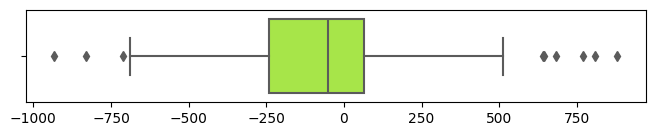

In [18]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=residuals_rural, color="greenyellow")